# Simulación de Plantas CSP y Análisis de Sensibilidad

Este notebook presenta una simulación termoeléctrica utilizando el modelo de torre central con almacenamiento en sales fundidas (CSP) mediante PySAM. Se evalúa el desempeño técnico y económico en distintos países, además de realizar un análisis de sensibilidad para parámetros clave como el múltiplo solar y las horas de almacenamiento térmico.


In [2]:
import PySAM.TcsmoltenSalt as TCSMS
import PySAM.Lcoefcr as Lcoefcr
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

## Definición de Funciones

En esta sección se definen las funciones necesarias para:
- Configurar el entorno de simulación (rutas, países y parámetros).
- Cargar archivos de datos climáticos.
- Ejecutar simulaciones CSP para diferentes ubicaciones.
- Realizar análisis de sensibilidad técnica y económica.


In [3]:
def configurar_entorno():
    """Define las rutas base, lista de países y crea directorios de salida."""
    # Rutas base - AJUSTA ESTAS RUTAS A TU ENTORNO
    # Intenta usar rutas relativas si es posible

    # Ejemplo de rutas relativas (preferible si la estructura es consistente)
    # datos_base_dir = os.path.join(base_repo_dir, "PRUEBA1", "Datos")
    # output_dir_results = os.path.join(base_repo_dir, "PRUEBA1", "Resultados")
    # output_dir_graphs = os.path.join(base_repo_dir, "PRUEBA1", "graficos")

    # Rutas absolutas (si las relativas no funcionan o prefieres explícitas)
    # Asegúrate que estas rutas existan o sean creadas correctamente
    #datos_base_dir = "/home/nicole/UA/NicoleTorres/PRUEBA1/Datos" # Ajustado a la estructura clonada
    #output_dir_results = "/home/nicole/UA/NicoleTorres/PRUEBA1/Resultados" # Ajustado
    #output_dir_graphs = "/home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_csp" # Ajustado

    datos_base_dir = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos" # Ajustado a la estructura clonada
    output_dir_results = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados" # Ajustado
    output_dir_graphs = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp"

    # Países a simular (Asegúrate que los archivos CSV existen)
    paises = [
        {"nombre": "Australia", "archivo_sufijo": "australia", "color": "blue"},
        {"nombre": "Chile", "archivo_sufijo": "chile", "color": "red"},
        {"nombre": "Espana", "archivo_sufijo": "espana", "color": "green"}
    ]

    # Crear directorios de salida si no existen
    if not os.path.exists(output_dir_results):
        os.makedirs(output_dir_results)
    if not os.path.exists(output_dir_graphs):
        os.makedirs(output_dir_graphs)

    # Parámetros fijos (se podrían mover a un archivo de config si crecen)
    config_params = {
        "fixed_charge_rate": 0.08,
        "fixed_operating_cost": 1000000,
        "variable_operating_cost": 0.02,
        "tshours_sensitivity": 12, # Para sensibilidad FCR
        "tshours_solarm_sens": 12, # Para sensibilidad Múltiplo Solar
        "fcr_solarm_sens": 0.08, # Para sensibilidad Múltiplo Solar
    }


    print("Directorios creados/verificados:")
    print(f"  Datos: {datos_base_dir}")
    print(f"  Resultados: {output_dir_results}")
    print(f"  Gráficos: {output_dir_graphs}")


    return {
        "datos_base_dir": datos_base_dir,
        "output_dir_results": output_dir_results,
        "output_dir_graphs": output_dir_graphs,
        "paises": paises,
        "params": config_params
    }

In [4]:
# Recurso Solar
import os
import pandas as pd # Mantener import por si se usa en otras celdas

def cargar_recurso_solar(pais_nombre, archivo_solar):
    """Carga los datos del recurso solar desde archivo CSV, usando siempre la ruta."""
    # Simplificado: Siempre devolver la ruta del archivo
    if os.path.exists(archivo_solar):
            print(f"  Usando referencia de archivo para {pais_nombre}: {archivo_solar}")
            # PySAM manejará la lectura del archivo directamente
            return {"solar_resource_file": archivo_solar}
    else:
        print(f"  ERROR: Archivo solar no encontrado para {pais_nombre}: {archivo_solar}")
        return None # Indicar fallo

In [43]:
# Cálculo Generación Energía y Costo Total Planta
def ejecutar_simulacion_principal(config):
    """Ejecuta la simulación principal variando las horas de almacenamiento y guarda CSV por país."""
    print("-" * 50)
    print("--- Iniciando Simulación Principal (Horas Almacenamiento 4-18 por País) ---")
    print("-" * 50)

    storage_hours_range = list(range(4, 19))  # Rango 4 a 18 horas
    resultado_totales = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        pais_sufijo = pais_info['archivo_sufijo'] # Usar sufijo para nombre de archivo
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_sufijo}.csv")
        output_dir = config["output_dir_results"] # Directorio de salida
        print(f"Procesando Simulación para: {pais_nombre}...")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
             print(f"  Saltando simulación para {pais_nombre} debido a error en recurso solar.")
             continue # Saltar al siguiente país

        # Listas para resultados de este país
        energy_generation = []
        plant_costs = []

        for tshours in storage_hours_range:
            print(f"    Simulando con {tshours} horas de almacenamiento...")
            try:
                csp_model = TCSMS.default("MSPTSingleOwner")
                csp_model.SolarResource.assign(resource_input) # Usar el recurso cargado
                csp_model.SystemDesign.assign({"tshours": tshours})
                csp_model.execute()

                annual_energy = csp_model.Outputs.annual_energy
                total_installed_cost = csp_model.Outputs.total_installed_cost
                print(f"      Simulación con {tshours} horas de almacenamiento ejecutada con éxito")
                print(f"        Generación anual de energía: {annual_energy:.0f} kWh")
                # Guardar los resultados de generación de energía y costo
                energy_generation.append(annual_energy)
                plant_costs.append(total_installed_cost)

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación ({tshours}h): {e}")
                # Añadir None a las listas si falla
                energy_generation.append(None)
                plant_costs.append(None)

        # Crear DataFrame para los resultados de este país
        df_results = pd.DataFrame({
            'Pais': pais_nombre,
            'Horas_almacenamiento': storage_hours_range,
            'Generacion_energia_kWh': energy_generation,
            'Costo_total_planta_$': plant_costs
        })

        #Calcular LCOE
        df_results['LCOE_$/kWh'] = df_results['Costo_total_planta_$'] / df_results['Generacion_energia_kWh']


        # Guardar los resultados en un archivo CSV específico para el país
        output_csv_pais = os.path.join(output_dir, f"resultados_{pais_sufijo}.csv")
        df_results.to_csv(output_csv_pais, index=False)
        print(f"  Resultados para {pais_nombre} guardados en {output_csv_pais}")
        print("-" * 20) # Separador entre países
        resultado_totales.append(df_results)
    
    #Concatenar todos los países
    df_total = pd.concat(resultado_totales, ignore_index=True)
    print("--- Simulación Principal Completada ---")
    return df_total


In [14]:
def ejecutar_sensibilidad_fcr(config):
    """Ejecuta el análisis de sensibilidad variando el FCR."""
    print("-" * 50)
    print("--- Iniciando Análisis de Sensibilidad FCR (por País) ---")
    print("-" * 50)

    tshours_sensitivity = config["params"]["tshours_sensitivity"]
    fcr_sensitivity_range = np.arange(0.05, 0.101, 0.01)
    output_csv_filename = "resultados_sensibilidad_fcr_multi.csv"
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Sensibilidad FCR para: {pais_nombre} ({tshours_sensitivity}h almacenamiento)... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando sensibilidad FCR para {pais_nombre} debido a error en recurso solar.")
            continue

        # Simular una vez para obtener energía y costo base
        try:
            csp_model_base = TCSMS.default("MSPTSingleOwner")
            csp_model_base.SolarResource.assign(resource_input) # Usar recurso cargado
            csp_model_base.SystemDesign.assign({"tshours": tshours_sensitivity})
            csp_model_base.execute()
            base_annual_energy = csp_model_base.Outputs.annual_energy
            base_total_cost = csp_model_base.Outputs.total_installed_cost
            print(f"    Energía base ({tshours_sensitivity}h): {base_annual_energy:.0f} kWh, Costo base: ${base_total_cost:,.0f}")
        except Exception as e:
            print(f"    ERROR al obtener energía/costo base para sensibilidad FCR: {e}. Saltando FCR para este país.")
            continue

        for fcr in fcr_sensitivity_range:
            print(f"    Calculando LCOE con FCR = {fcr:.3f}...")
            try:
                lcoe_model_sens = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model_sens.SimpleLCOE.assign({
                    "annual_energy": base_annual_energy,
                    "capital_cost": base_total_cost,
                    "fixed_charge_rate": fcr,
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model_sens.execute()
                lcoe_sens = lcoe_model_sens.Outputs.lcoe_fcr
                print(f"      LCOE: {lcoe_sens:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Tasa_carga_fija': fcr,
                    'Generacion_energia_kWh': base_annual_energy,
                    'Costo_total_planta_$': base_total_cost,
                    'LCOE_$/kWh': lcoe_sens
                })
            except Exception as e:
                print(f"      ERROR al calcular LCOE para FCR={fcr:.3f}: {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Tasa_carga_fija': fcr,
                    'Generacion_energia_kWh': base_annual_energy, 'Costo_total_planta_$': base_total_cost, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados sensibilidad FCR combinados guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados sensibilidad FCR: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en el análisis de sensibilidad FCR.")
        return pd.DataFrame()

    return df_results

In [30]:
def ejecutar_sensibilidad_multiplo_solar(config):
    """Ejecuta el análisis de sensibilidad variando el Múltiplo Solar."""
    print("-" * 50)
    print("--- Iniciando Análisis de Sensibilidad Múltiplo Solar (por País) ---")
    print("-" * 50)

    tshours_solarm_sens = config["params"]["tshours_solarm_sens"]
    fcr_solarm_sens = config["params"]["fcr_solarm_sens"]
    solarm_sensitivity_range = np.arange(1.5, 3.01, 0.25)
    output_csv_filename = "resultados_sensibilidad_solarm_multi.csv"
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Sensibilidad Múltiplo Solar para: {pais_nombre} ({tshours_solarm_sens}h almacenamiento, FCR={fcr_solarm_sens})... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando sensibilidad Múltiplo Solar para {pais_nombre} debido a error en recurso solar.")
            continue

        for solarm in solarm_sensitivity_range:
            print(f"    Simulando con Múltiplo Solar = {solarm:.2f}...")
            try:
                csp_model_solarm = TCSMS.default("MSPTSingleOwner")
                csp_model_solarm.SolarResource.assign(resource_input) # Usar recurso cargado
                csp_model_solarm.SystemDesign.assign({"tshours": tshours_solarm_sens, "solarm": solarm})
                csp_model_solarm.execute()

                annual_energy_solarm = csp_model_solarm.Outputs.annual_energy
                total_installed_cost_solarm = csp_model_solarm.Outputs.total_installed_cost

                lcoe_model_solarm = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model_solarm.SimpleLCOE.assign({
                    "annual_energy": annual_energy_solarm,
                    "capital_cost": total_installed_cost_solarm,
                    "fixed_charge_rate": fcr_solarm_sens,
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model_solarm.execute()
                lcoe_solarm = lcoe_model_solarm.Outputs.lcoe_fcr
                print(f"      Energía: {annual_energy_solarm:.0f} kWh, Costo: ${total_installed_cost_solarm:,.0f}, LCOE: {lcoe_solarm:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Multiplo_Solar': solarm,
                    'Generacion_energia_kWh': annual_energy_solarm,
                    'Costo_total_planta_$': total_installed_cost_solarm,
                    'LCOE_$/kWh': lcoe_solarm
                })

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación (Múltiplo Solar={solarm:.2f}): {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Multiplo_Solar': solarm,
                    'Generacion_energia_kWh': None, 'Costo_total_planta_$': None, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados sensibilidad Múltiplo Solar combinados guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados sensibilidad Múltiplo Solar: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en el análisis de sensibilidad de Múltiplo Solar.")
        return pd.DataFrame()

    return df_results

In [26]:
# Graficos Comparativos
import matplotlib.pyplot as plt  # Asegurar importación
import matplotlib.ticker as mticker # Asegurar importación
import os # Asegurar importación
import pandas as pd # Asegurar importación (si se usa pd dentro)
import numpy as np # Asegurar importación (para np.nan)
import traceback # Para imprimir detalles de errores

def generar_graficos_comparativos(config, df_main, df_fcr, df_solarm, nombre_grafico):
    """Genera UN gráfico comparativo 2D específico a partir de los DataFrames de resultados.

    Args:
        config (dict): Diccionario de configuración.
        df_main (pd.DataFrame): DataFrame de la simulación principal (variando horas). Puede ser None.
        df_fcr (pd.DataFrame): DataFrame de la sensibilidad FCR. Puede ser None.
        df_solarm (pd.DataFrame): DataFrame de la sensibilidad Múltiplo Solar. Puede ser None.
        nombre_grafico (str): Nombre clave del gráfico a generar. Opciones:
            'lcoe_vs_horas', 'energia_vs_horas', 'costo_vs_horas',
            'sens_lcoe_fcr', 'sens_lcoe_solarm'.
    """
    print("-" * 50)
    print(f"--- Generando Gráfico Específico: {nombre_grafico} --- ")
    print("-" * 50)

    # --- Acceso seguro a config y creación de directorio ---
    output_dir_graphs = config.get("output_dir_graphs")
    if not output_dir_graphs:
        print("Advertencia: No se encontró 'output_dir_graphs' en la configuración. Usando directorio actual para gráficos.")
        output_dir_graphs = "."
    try:
        os.makedirs(output_dir_graphs, exist_ok=True) # Crea el directorio si no existe
    except OSError as e:
        print(f"Error al crear el directorio de gráficos '{output_dir_graphs}': {e}. Se usará el directorio actual.")
        output_dir_graphs = "."


    # Paleta de colores robusta (usa 'gray' si falta color o nombre)
    palette = {pais.get("nombre", f"Pais_{i}"): pais.get("color", 'gray')
               for i, pais in enumerate(config.get("paises", []))}

    # Parámetros para títulos (con .get() para seguridad)
    params_config = config.get("params", {})
    tshours_sensitivity = params_config.get("tshours_sensitivity", "N/A")
    tshours_solarm_sens = params_config.get("tshours_solarm_sens", "N/A")
    fcr_solarm_sens = params_config.get("fcr_solarm_sens", np.nan) # Usar NaN si falta
    # --- Fin acceso seguro a config ---

    # Validar nombre_grafico
    graficos_validos = ['lcoe_vs_horas', 'energia_vs_horas', 'costo_vs_horas', 'sens_lcoe_fcr', 'sens_lcoe_solarm']
    if nombre_grafico not in graficos_validos:
        print(f"Error: Nombre de gráfico '{nombre_grafico}' no es válido. Opciones: {graficos_validos}")
        return

    # Generar gráfico específico
    plt.figure(figsize=(10, 6))
    graph_generated = False
    graph_path = ""

    try:
        # Verificar DataFrames antes de usarlos
        if nombre_grafico == 'lcoe_vs_horas':
            # Asegurarse que df_main existe, no está vacío y tiene las columnas necesarias
            if df_main is not None and not df_main.empty and all(col in df_main.columns for col in ['Pais', 'Horas_almacenamiento', 'LCOE_$/kWh']):
                for pais, group in df_main.groupby('Pais'):
                    plt.plot(group['Horas_almacenamiento'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Horas de Almacenamiento')
                plt.ylabel('LCOE ($/kWh)')
                plt.title('LCOE vs Horas de Almacenamiento por País (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
                graph_path = os.path.join(output_dir_graphs, "comparativo_lcoe_vs_horas_csp.png")
                graph_generated = True
            else:
                print("Saltando gráfico 'lcoe_vs_horas' (DataFrame 'df_main' vacío, None o faltan columnas).")

        elif nombre_grafico == 'energia_vs_horas':
             if df_main is not None and not df_main.empty and all(col in df_main.columns for col in ['Pais', 'Horas_almacenamiento', 'Generacion_energia_kWh']):
                for pais, group in df_main.groupby('Pais'):
                    plt.plot(group['Horas_almacenamiento'], group['Generacion_energia_kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Horas de Almacenamiento')
                plt.ylabel('Generación Anual (kWh)')
                plt.title('Generación Anual vs Horas de Almacenamiento por País (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f')) # Formato sin decimales
                graph_path = os.path.join(output_dir_graphs, "comparativo_energia_vs_horas_csp.png")
                graph_generated = True
             else:
                print("Saltando gráfico 'energia_vs_horas' (DataFrame 'df_main' vacío, None o faltan columnas).")

        elif nombre_grafico == 'costo_vs_horas':
            if df_main is not None and not df_main.empty and all(col in df_main.columns for col in ['Pais', 'Horas_almacenamiento', 'Costo_total_planta_$']):
                for pais, group in df_main.groupby('Pais'):
                    plt.plot(group['Horas_almacenamiento'], group['Costo_total_planta_$'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Horas de Almacenamiento')
                plt.ylabel('Costo Total Planta ($)')
                plt.title('Costo Total Planta vs Horas de Almacenamiento por País (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
                graph_path = os.path.join(output_dir_graphs, "comparativo_costo_vs_horas_csp.png")
                graph_generated = True
            else:
                print("Saltando gráfico 'costo_vs_horas' (DataFrame 'df_main' vacío, None o faltan columnas).")

        elif nombre_grafico == 'sens_lcoe_fcr':
            if df_fcr is not None and not df_fcr.empty and all(col in df_fcr.columns for col in ['Pais', 'Tasa_carga_fija', 'LCOE_$/kWh']):
                for pais, group in df_fcr.groupby('Pais'):
                    plt.plot(group['Tasa_carga_fija'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Tasa Carga Fija (FCR)')
                plt.ylabel('LCOE ($/kWh)')
                plt.title(f'Sensibilidad LCOE a FCR por País ({tshours_sensitivity}h Almacenamiento) (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
                graph_path = os.path.join(output_dir_graphs, "comparativo_sensibilidad_lcoe_vs_fcr_csp.png")
                graph_generated = True
            else:
                print("Saltando gráfico 'sens_lcoe_fcr' (DataFrame 'df_fcr' vacío, None o faltan columnas).")

        elif nombre_grafico == 'sens_lcoe_solarm':
            if df_solarm is not None and not df_solarm.empty and all(col in df_solarm.columns for col in ['Pais', 'Multiplo_Solar', 'LCOE_$/kWh']):
                # Formatear FCR para título de forma segura
                fcr_solarm_sens_str = f"{fcr_solarm_sens:.2f}" if not np.isnan(fcr_solarm_sens) else "N/A"
                for pais, group in df_solarm.groupby('Pais'):
                    plt.plot(group['Multiplo_Solar'], group['LCOE_$/kWh'], marker='o', linestyle='-', color=palette.get(pais, 'gray'), label=pais)
                plt.xlabel('Múltiplo Solar')
                plt.ylabel('LCOE ($/kWh)')
                plt.title(f'Sensibilidad LCOE a Múltiplo Solar por País ({tshours_solarm_sens}h, FCR={fcr_solarm_sens_str}) (CSP)')
                plt.legend(title='País')
                plt.grid(True, linestyle='--')
                plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
                plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.4f'))
                graph_path = os.path.join(output_dir_graphs, "comparativo_sensibilidad_lcoe_vs_solarm_csp.png")
                graph_generated = True
            else:
                 print("Saltando gráfico 'sens_lcoe_solarm' (DataFrame 'df_solarm' vacío, None o faltan columnas).")

        # Guardar y mostrar si se generó
        if graph_generated:
            plt.tight_layout()
            plt.savefig(graph_path)
            plt.show()
            plt.close()
            print(f"Gráfico {nombre_grafico} guardado en {graph_path}")
        else:
            plt.close() # Cerrar la figura si no se usó

    except Exception as e:
        print(f"Error generando gráfico '{nombre_grafico}': {e}")
        traceback.print_exc() # Imprimir detalles del error
        plt.close() # Asegurarse de cerrar la figura en caso de error

    print("-" * 50)
# Final de la definición de la función

In [17]:
def ejecutar_simulacion_variando_solarm(config):
    """Ejecuta simulación variando Múltiplo Solar para un almacenamiento y FCR fijos."""
    print("-" * 50)
    print("--- Iniciando Simulación Variando Múltiplo Solar (por País) ---")
    print("-" * 50)

    tshours_fixed = config["params"]["tshours_solarm_sens"] # Usamos el mismo valor que en la sensibilidad
    fcr_fixed = config["params"]["fcr_solarm_sens"]      # Usamos el mismo valor que en la sensibilidad
    solarm_range = np.arange(1.5, 3.51, 0.25) # Rango más amplio para Múltiplo Solar
    output_csv_filename = "resultados_simulacion_csp_variando_solarm.csv" # Nuevo archivo de resultados
    results_all = []

    for pais_info in config["paises"]:
        pais_nombre = pais_info["nombre"]
        archivo_solar = os.path.join(config["datos_base_dir"], f"{pais_info['archivo_sufijo']}.csv")
        print(f"Procesando Simulación Variando Múltiplo Solar para: {pais_nombre} ({tshours_fixed}h almacenamiento, FCR={fcr_fixed:.2f})... ")

        resource_input = cargar_recurso_solar(pais_nombre, archivo_solar)
        if resource_input is None:
            print(f"  Saltando simulación variando Múltiplo Solar para {pais_nombre} debido a error en recurso solar.")
            continue

        for solarm in solarm_range:
            print(f"    Simulando con Múltiplo Solar = {solarm:.2f}...")
            try:
                csp_model = TCSMS.default("MSPTSingleOwner")
                csp_model.SolarResource.assign(resource_input) # Usar recurso cargado
                # Fijar horas de almacenamiento y variar múltiplo solar
                csp_model.SystemDesign.assign({"tshours": tshours_fixed, "solarm": solarm})
                csp_model.execute()

                annual_energy = csp_model.Outputs.annual_energy
                total_installed_cost = csp_model.Outputs.total_installed_cost

                lcoe_model = Lcoefcr.default("GenericCSPSystemLCOECalculator")
                lcoe_model.SimpleLCOE.assign({
                    "annual_energy": annual_energy,
                    "capital_cost": total_installed_cost,
                    "fixed_charge_rate": fcr_fixed, # Usar FCR fijo
                    "fixed_operating_cost": config["params"]["fixed_operating_cost"],
                    "variable_operating_cost": config["params"]["variable_operating_cost"]
                })
                lcoe_model.execute()
                lcoe = lcoe_model.Outputs.lcoe_fcr
                print(f"      Energía: {annual_energy:.0f} kWh, Costo: ${total_installed_cost:,.0f}, LCOE: {lcoe:.4f} $/kWh")

                results_all.append({
                    'Pais': pais_nombre,
                    'Multiplo_Solar': solarm,
                    'Horas_Almacenamiento_Fijas': tshours_fixed,
                    'FCR_Fijo': fcr_fixed,
                    'Generacion_energia_kWh': annual_energy,
                    'Costo_total_planta_$': total_installed_cost,
                    'LCOE_$/kWh': lcoe
                })

            except Exception as e:
                print(f"      ERROR al ejecutar la simulación (Múltiplo Solar={solarm:.2f}): {e}")
                results_all.append({
                    'Pais': pais_nombre, 'Multiplo_Solar': solarm,
                    'Horas_Almacenamiento_Fijas': tshours_fixed, 'FCR_Fijo': fcr_fixed,
                    'Generacion_energia_kWh': None, 'Costo_total_planta_$': None, 'LCOE_$/kWh': None
                })

    # Guardar resultados
    df_results = pd.DataFrame(results_all)
    df_results.dropna(inplace=True)
    if not df_results.empty:
        output_path = os.path.join(config["output_dir_results"], output_csv_filename)
        try:
            df_results.to_csv(output_path, index=False, float_format='%.4f')
            print(f"Resultados simulación variando Múltiplo Solar guardados en {output_path}")
        except Exception as e:
            print(f"ERROR al guardar resultados simulación variando Múltiplo Solar: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados válidos en la simulación variando Múltiplo Solar.")
        return pd.DataFrame()

    return df_results


---------------------------------------------------------------------------------------------------------------------------
## Configuración Inicial

Se establece el entorno de trabajo inicial, incluyendo:
- Las rutas de entrada y salida de datos.
- La lista de países a simular (Australia, Chile, España).
- La creación o verificación de carpetas necesarias para guardar resultados y gráficos.
- Los parámetros base para el análisis económico y técnico.

In [18]:
configuracion = configurar_entorno()

Directorios creados/verificados:
  Datos: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos
  Resultados: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados
  Gráficos: /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp


## Simulación Principal CSP

En esta sección se realiza la simulación principal del sistema CSP para cada país. Se analizan los siguientes aspectos clave:

- **Generación eléctrica anual** de la planta.
- **Horas de almacenamiento térmico** utilizadas en la simulación.
- **Costo total de la planta**, considerando inversión, operación y mantenimiento.

Los resultados permiten comparar el desempeño técnico y económico de la tecnología CSP bajo distintas condiciones climáticas.


In [44]:
resultados_main = ejecutar_simulacion_principal(configuracion)

--------------------------------------------------
--- Iniciando Simulación Principal (Horas Almacenamiento 4-18 por País) ---
--------------------------------------------------
Procesando Simulación para: Australia...
  Usando referencia de archivo para Australia: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/australia.csv
    Simulando con 4 horas de almacenamiento...


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Simulación con 4 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 378230920 kWh
    Simulando con 5 horas de almacenamiento...
      Simulación con 5 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 408549945 kWh
    Simulando con 6 horas de almacenamiento...
      Simulación con 6 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 437164826 kWh
    Simulando con 7 horas de almacenamiento...
      Simulación con 7 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 464044930 kWh
    Simulando con 8 horas de almacenamiento...
      Simulación con 8 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 489594765 kWh
    Simulando con 9 horas de almacenamiento...


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Simulación con 9 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 513703257 kWh
    Simulando con 10 horas de almacenamiento...
      Simulación con 10 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 536121797 kWh
    Simulando con 11 horas de almacenamiento...
      Simulación con 11 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 555326773 kWh
    Simulando con 12 horas de almacenamiento...
      Simulación con 12 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 573048696 kWh
    Simulando con 13 horas de almacenamiento...
      Simulación con 13 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 589187593 kWh
    Simulando con 14 horas de almacenamiento...


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Simulación con 14 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 604638929 kWh
    Simulando con 15 horas de almacenamiento...


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Simulación con 15 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 612709475 kWh
    Simulando con 16 horas de almacenamiento...
      Simulación con 16 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 618435858 kWh
    Simulando con 17 horas de almacenamiento...
      Simulación con 17 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 621022056 kWh
    Simulando con 18 horas de almacenamiento...


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Simulación con 18 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 622635197 kWh
  Resultados para Australia guardados en /home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados/resultados_australia.csv
--------------------
Procesando Simulación para: Chile...
  Usando referencia de archivo para Chile: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/chile.csv
    Simulando con 4 horas de almacenamiento...
      Simulación con 4 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 513948347 kWh
    Simulando con 5 horas de almacenamiento...
      Simulación con 5 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 551774615 kWh
    Simulando con 6 horas de almacenamiento...
      Simulación con 6 horas de almacenamiento ejecutada con éxito
        Generación anual de energía: 587542939 kWh
    Simulando con 7 horas de almacenamiento...
      Simulación con 7 horas de almacenamiento ejecutada co

## Análisis de Sensibilidad del Fixed Charge Rate (FCR)

Se evalúa cómo varía el **LCOE financiero** en función del parámetro *Fixed Charge Rate* (FCR), que representa la tasa de retorno requerida para recuperar la inversión del proyecto.

Este análisis permite entender la influencia de las condiciones financieras locales sobre la competitividad de la tecnología CSP en cada país simulado.


In [32]:
resultados_fcr = ejecutar_sensibilidad_fcr(configuracion)

--------------------------------------------------
--- Iniciando Análisis de Sensibilidad FCR (por País) ---
--------------------------------------------------
Procesando Sensibilidad FCR para: Australia (12h almacenamiento)... 
  Usando referencia de archivo para Australia: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/australia.csv
    Energía base (12h): 573048696 kWh, Costo base: $677,767,677
    Calculando LCOE con FCR = 0.050...
      LCOE: 0.0809 $/kWh
    Calculando LCOE con FCR = 0.060...
      LCOE: 0.0927 $/kWh
    Calculando LCOE con FCR = 0.070...
      LCOE: 0.1045 $/kWh
    Calculando LCOE con FCR = 0.080...
      LCOE: 0.1164 $/kWh
    Calculando LCOE con FCR = 0.090...
      LCOE: 0.1282 $/kWh
    Calculando LCOE con FCR = 0.100...
      LCOE: 0.1400 $/kWh
Procesando Sensibilidad FCR para: Chile (12h almacenamiento)... 
  Usando referencia de archivo para Chile: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/chile.csv
    Energía base (12h): 695546060 kWh, Costo b

S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


Resultados sensibilidad FCR combinados guardados en /home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados/resultados_sensibilidad_fcr_multi.csv


## Análisis de Sensibilidad del Múltiplo Solar

Se analiza el impacto del **múltiplo solar** sobre la producción de energía y el costo nivelado (LCOE). El múltiplo solar representa el sobredimensionamiento del campo solar respecto a la potencia del bloque de potencia.

Este parámetro es clave para optimizar la integración entre generación solar y almacenamiento térmico, afectando directamente la eficiencia del sistema y su viabilidad económica.


In [33]:
resultados_solarm = ejecutar_sensibilidad_multiplo_solar(configuracion)

--------------------------------------------------
--- Iniciando Análisis de Sensibilidad Múltiplo Solar (por País) ---
--------------------------------------------------
Procesando Sensibilidad Múltiplo Solar para: Australia (12h almacenamiento, FCR=0.08)... 
  Usando referencia de archivo para Australia: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/australia.csv
    Simulando con Múltiplo Solar = 1.50...
      Energía: 428632304 kWh, Costo: $677,767,677, LCOE: 0.1488 $/kWh
    Simulando con Múltiplo Solar = 1.75...
      Energía: 495606797 kWh, Costo: $677,767,677, LCOE: 0.1314 $/kWh
    Simulando con Múltiplo Solar = 2.00...


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Energía: 541162656 kWh, Costo: $677,767,677, LCOE: 0.1220 $/kWh
    Simulando con Múltiplo Solar = 2.25...
      Energía: 564050745 kWh, Costo: $677,767,677, LCOE: 0.1179 $/kWh
    Simulando con Múltiplo Solar = 2.50...
      Energía: 577827100 kWh, Costo: $677,767,677, LCOE: 0.1156 $/kWh
    Simulando con Múltiplo Solar = 2.75...
      Energía: 586331021 kWh, Costo: $677,767,677, LCOE: 0.1142 $/kWh
    Simulando con Múltiplo Solar = 3.00...
      Energía: 588731682 kWh, Costo: $677,767,677, LCOE: 0.1138 $/kWh
Procesando Sensibilidad Múltiplo Solar para: Chile (12h almacenamiento, FCR=0.08)... 
  Usando referencia de archivo para Chile: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/chile.csv
    Simulando con Múltiplo Solar = 1.50...


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Energía: 616360689 kWh, Costo: $677,767,677, LCOE: 0.1096 $/kWh
    Simulando con Múltiplo Solar = 1.75...
      Energía: 676105623 kWh, Costo: $677,767,677, LCOE: 0.1017 $/kWh
    Simulando con Múltiplo Solar = 2.00...
      Energía: 699930797 kWh, Costo: $677,767,677, LCOE: 0.0989 $/kWh
    Simulando con Múltiplo Solar = 2.25...
      Energía: 698525284 kWh, Costo: $677,767,677, LCOE: 0.0991 $/kWh
    Simulando con Múltiplo Solar = 2.50...
      Energía: 693617548 kWh, Costo: $677,767,677, LCOE: 0.0996 $/kWh
    Simulando con Múltiplo Solar = 2.75...
      Energía: 688842924 kWh, Costo: $677,767,677, LCOE: 0.1002 $/kWh
    Simulando con Múltiplo Solar = 3.00...
      Energía: 682524951 kWh, Costo: $677,767,677, LCOE: 0.1009 $/kWh
Procesando Sensibilidad Múltiplo Solar para: Espana (12h almacenamiento, FCR=0.08)... 
  Usando referencia de archivo para Espana: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/espana.csv
    Simulando con Múltiplo Solar = 1.50...
      Energía: 430

In [34]:
# 4.5 Ejecutar simulación variando Múltiplo Solar
resultados_variando_solarm = ejecutar_simulacion_variando_solarm(configuracion)

--------------------------------------------------
--- Iniciando Simulación Variando Múltiplo Solar (por País) ---
--------------------------------------------------
Procesando Simulación Variando Múltiplo Solar para: Australia (12h almacenamiento, FCR=0.08)... 
  Usando referencia de archivo para Australia: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/australia.csv
    Simulando con Múltiplo Solar = 1.50...
      Energía: 428632304 kWh, Costo: $677,767,677, LCOE: 0.1488 $/kWh
    Simulando con Múltiplo Solar = 1.75...
      Energía: 495606797 kWh, Costo: $677,767,677, LCOE: 0.1314 $/kWh
    Simulando con Múltiplo Solar = 2.00...
      Energía: 541162656 kWh, Costo: $677,767,677, LCOE: 0.1220 $/kWh
    Simulando con Múltiplo Solar = 2.25...
      Energía: 564050745 kWh, Costo: $677,767,677, LCOE: 0.1179 $/kWh
    Simulando con Múltiplo Solar = 2.50...
      Energía: 577827100 kWh, Costo: $677,767,677, LCOE: 0.1156 $/kWh
    Simulando con Múltiplo Solar = 2.75...
      Energía: 5863

S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Energía: 588081394 kWh, Costo: $677,767,677, LCOE: 0.1139 $/kWh
    Simulando con Múltiplo Solar = 3.50...
      Energía: 587045515 kWh, Costo: $677,767,677, LCOE: 0.1141 $/kWh
Procesando Simulación Variando Múltiplo Solar para: Chile (12h almacenamiento, FCR=0.08)... 
  Usando referencia de archivo para Chile: /home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos/chile.csv
    Simulando con Múltiplo Solar = 1.50...


S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2
S_decode ==> Please fix the hour: -3
S_decode ==> Please fix the hour: -1
S_decode ==> Please fix the hour: -2


      Energía: 616360689 kWh, Costo: $677,767,677, LCOE: 0.1096 $/kWh
    Simulando con Múltiplo Solar = 1.75...
      Energía: 676105623 kWh, Costo: $677,767,677, LCOE: 0.1017 $/kWh
    Simulando con Múltiplo Solar = 2.00...
      Energía: 699930797 kWh, Costo: $677,767,677, LCOE: 0.0989 $/kWh
    Simulando con Múltiplo Solar = 2.25...
      Energía: 698525284 kWh, Costo: $677,767,677, LCOE: 0.0991 $/kWh
    Simulando con Múltiplo Solar = 2.50...
      Energía: 693617548 kWh, Costo: $677,767,677, LCOE: 0.0996 $/kWh
    Simulando con Múltiplo Solar = 2.75...
      Energía: 688842924 kWh, Costo: $677,767,677, LCOE: 0.1002 $/kWh
    Simulando con Múltiplo Solar = 3.00...
      Energía: 682524951 kWh, Costo: $677,767,677, LCOE: 0.1009 $/kWh
    Simulando con Múltiplo Solar = 3.25...
      Energía: 676146730 kWh, Costo: $677,767,677, LCOE: 0.1017 $/kWh
    Simulando con Múltiplo Solar = 3.50...
      Energía: 667882061 kWh, Costo: $677,767,677, LCOE: 0.1027 $/kWh
Procesando Simulación Vari

## Gráficos Comparativos

Se presentan visualizaciones comparativas entre países para los distintos análisis realizados:

- Producción anual de energía.
- LCOE en función del FCR.
- LCOE en función del múltiplo solar.

Estos gráficos permiten identificar diferencias de desempeño según condiciones climáticas y escenarios financieros en Australia, Chile y España.


--------------------------------------------------
--- Generando Gráfico Específico: lcoe_vs_horas --- 
--------------------------------------------------


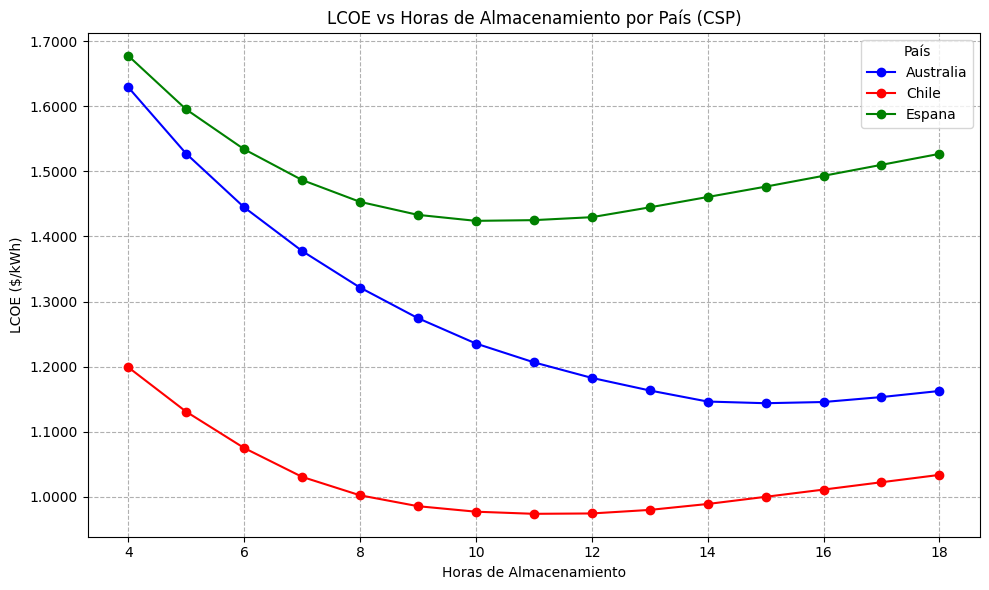

Gráfico lcoe_vs_horas guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_lcoe_vs_horas_csp.png
--------------------------------------------------


In [45]:
# Generar gráfico LCOE vs Horas
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'lcoe_vs_horas')


### Interpretación del gráfico: LCOE vs Horas de Almacenamiento

El gráfico muestra cómo varía el **Costo Nivelado de Energía (LCOE)** de plantas CSP en función de las horas de almacenamiento térmico, para tres ubicaciones: Chile, España y Australia.

**Observaciones clave:**

- En **Chile** y **España**, el LCOE disminuye levemente hasta un mínimo (alrededor de 10-12 horas de almacenamiento), lo que indica una mejora en la utilización del sistema sin un aumento proporcional en los costos de inversión.
- En **Australia**, el LCOE aumenta continuamente con más horas de almacenamiento, lo que sugiere una menor eficiencia en la conversión o menores niveles de DNI en comparación con los otros países.
- El valor absoluto del LCOE en Chile es el más bajo en todo el rango, indicando una excelente competitividad de la tecnología CSP en ese país.

**Conclusión:**  
Agregar almacenamiento térmico hasta cierto punto (≈10-12 horas) puede reducir el LCOE en sitios con alta irradiancia como Chile y España, pero no necesariamente en ubicaciones con menor recurso solar. Esto destaca la importancia del análisis local en la planificación de proyectos CSP.


--------------------------------------------------
--- Generando Gráfico Específico: energia_vs_horas --- 
--------------------------------------------------


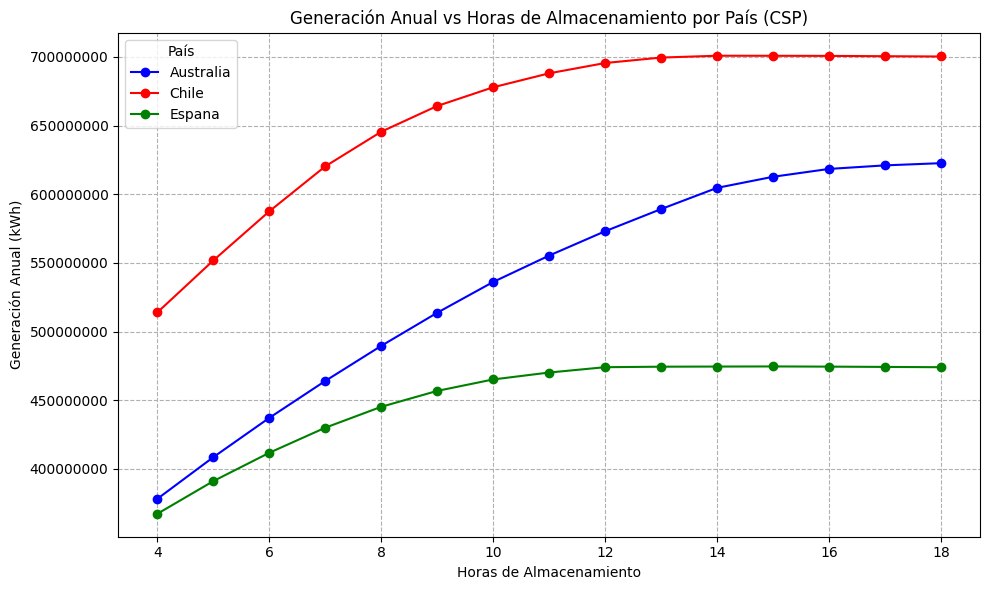

Gráfico energia_vs_horas guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_energia_vs_horas_csp.png
--------------------------------------------------


In [46]:
# Generar gráfico Energía vs Horas
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'energia_vs_horas')


--------------------------------------------------
--- Generando Gráfico Específico: costo_vs_horas --- 
--------------------------------------------------


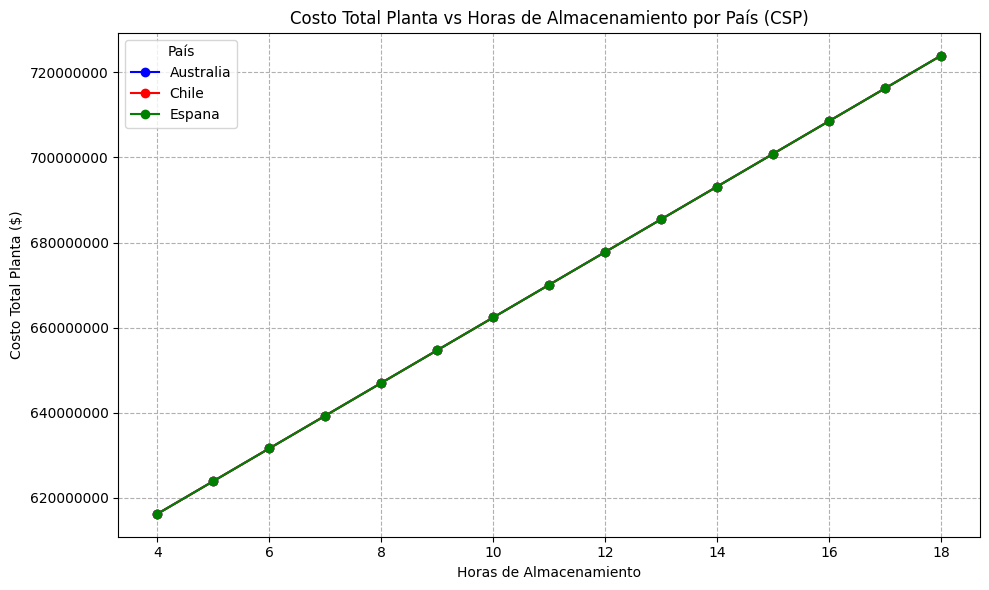

Gráfico costo_vs_horas guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_costo_vs_horas_csp.png
--------------------------------------------------


In [47]:
# Generar gráfico Costo vs Horas
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'costo_vs_horas')


--------------------------------------------------
--- Generando Gráfico Específico: sens_lcoe_fcr --- 
--------------------------------------------------


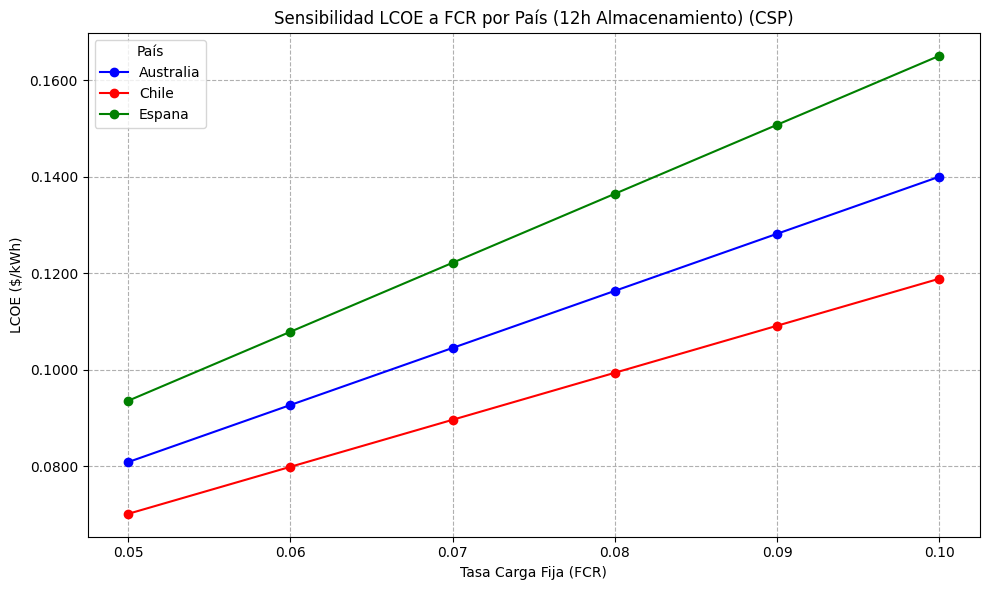

Gráfico sens_lcoe_fcr guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_sensibilidad_lcoe_vs_fcr_csp.png
--------------------------------------------------


In [48]:
# Generar gráfico Sensibilidad LCOE vs FCR
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'sens_lcoe_fcr')

# Generar gráfico Sensibilidad LCOE vs Múltiplo Solar

--------------------------------------------------
--- Generando Gráfico Específico: sens_lcoe_solarm --- 
--------------------------------------------------


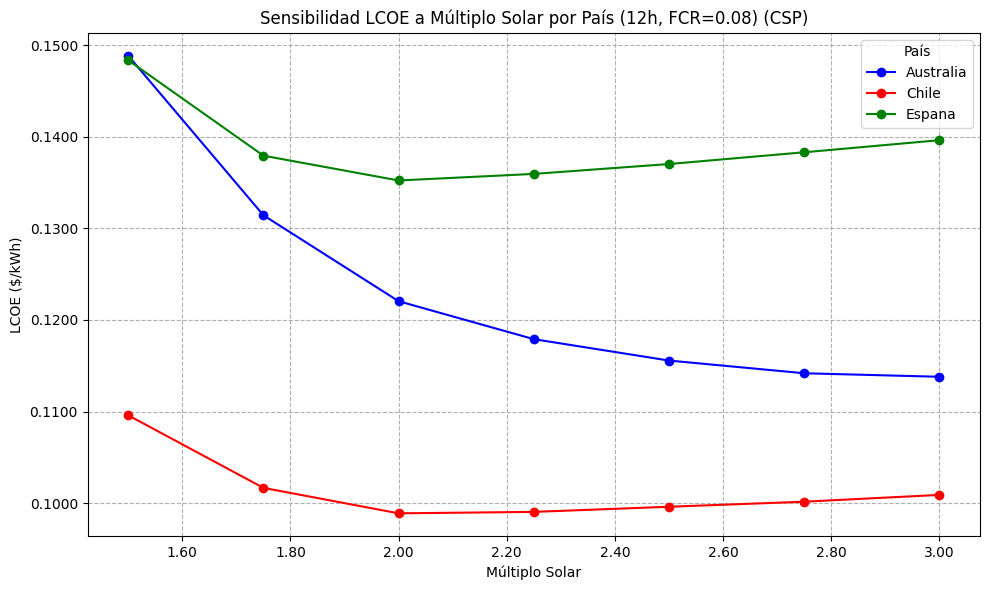

Gráfico sens_lcoe_solarm guardado en /home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_csp/comparativo_sensibilidad_lcoe_vs_solarm_csp.png
--------------------------------------------------


In [49]:
#  Generar gráfico comparativo de LCOE vs Múltiplo Solar
generar_graficos_comparativos(configuracion, resultados_main, resultados_fcr, resultados_solarm, 'sens_lcoe_solarm')